# Intro

Here we use ALL perturbed cell-types.
This is done when we generate the pseudobulks by sampling from both perturbed or non-perturbed cells within each sample.

This data QCs the Kang et.al. data to make sure everything looks good.
The data was retreived using  the SeuratData package in R and then translated into an AnnData object to be read into python,
Notebook for SeuratData analysis of Kang data (names ifnb in SeuratData): https://satijalab.org/seurat/articles/integration_introduction.html
Seurat Disk was used for conversion between h5Seurat and AnnData: https://mojaveazure.github.io/seurat-disk/articles/convert-anndata.html

Kang data is originally from here: 
Kang, Hyun Min, et al. "Multiplexed droplet single-cell RNA-sequencing using natural genetic variation." Nature biotechnology 36.1 (2018): 89-94.

This based off of the tutorial from scanpy using pbmc 3K.
https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html

And heavily influenced by https://github.com/theislab/scanpy_usage/blob/master/170503_zheng17/zheng17.ipynb

# Imports

In [3]:
import sys
sys.path.insert(1, '../../')
sys.path.insert(1, '../')
from preprocessing import sc_preprocess


# general imports
import warnings
import numpy as np
import os
import pandas as pd
import scipy as sp
from scipy.sparse import coo_matrix
import collections
import scanpy as sc


# Images, plots, display, and visualization
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.manifold import TSNE
import sklearn as sk

# matplotlib settings for Jupyter notebooks only
%matplotlib inline

import pickle
import gzip
from pathlib import Path


In [4]:
from importlib import reload  # Python 3.4+
reload(sc_preprocess)


<module 'preprocessing.sc_preprocess' from '/beevol/home/davidson/checkouts/buddi/buddi/sc_preprocessing/2_make_pseudobulks/../../preprocessing/sc_preprocess.py'>

# Parameters

In [7]:
# parameters

aug_data_path = f"{os.getcwd()}/../../../../sc_bulk_ood/data/single_cell_data/augmented_liver_data/"
cibersort_path = f"{os.getcwd()}/../../../../sc_bulk_ood/data/single_cell_data/cibersort_liver/"
data_path = f"{os.getcwd()}/../../../../sc_bulk_ood/data/single_cell_data/liver_sex/"



#####################
### set the study ###
#####################

res_name = "all-liver"
in_name = "liver_droplet_processed"
processed_sc_file = f"{data_path}/{in_name}.h5ad"



# Load and Process data

### Read in data and metadata

In [8]:
# read in the data

adata = sc.read_h5ad(processed_sc_file)

adata.var_names_make_unique()  # this is unnecessary if using `var_names='gene_ids'` in `sc.read_10x_mtx`



In [9]:
# format metadata


def get_stim_id(in_str):
    out_str = "STIM"
    if in_str == "male":
        out_str = "CTRL"
           
    return(out_str)


adata.obs['CellType'] = adata.obs['names_merged'].tolist()
adata.obs['scpred_CellType'] = adata.obs['names_merged'].tolist()
adata.obs['sample_id'] = adata.obs['mouse.id'].tolist()
adata.obs['stim'] = [get_stim_id(str(x)) for x in adata.obs['sex'].tolist()]

adata.var['gene_ids'] = adata.var.index.tolist()


In [10]:
np.where(adata.var['gene_ids'] == "Cd74")

(array([6062]),)

In [11]:
# we are going to combine a few cell types
tab = adata.obs.groupby(['sample_id', 'stim']).size()

tab.unstack()

stim,CTRL,STIM
sample_id,,
18-F-51,NaN,698.0
30-M-5,362.0,NaN


In [12]:
adata.obs

,age,cell,cell_ontology_class,cell_ontology_id,free_annotation,method,mouse.id,n_genes,sex,subtissue,...,names_merged,keep,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,CellType,scpred_CellType,sample_id,stim
index,,,,,,,,,,,,,,,,,,,,,
AAACCTGAGATGTCGG-1-9-0-0,18m,MACA_18m_F_LIVER_HEPATOCYTES_51_AAACCTGAGATGTCGG,hepatocyte,NA,nan,droplet,18-F-51,1116,female,Hepatocytes,...,hepatocyte,yes,1115,2800.0,0.0,0.0,hepatocyte,hepatocyte,18-F-51,STIM
AAAGCAATCGGAAATA-1-9-0-0,18m,MACA_18m_F_LIVER_HEPATOCYTES_51_AAAGCAATCGGAAATA,hepatocyte,NA,"Hepatocyte (Pericentral, Midlobular, Periportal)",droplet,18-F-51,1976,female,Hepatocytes,...,hepatocyte,yes,1976,5403.0,0.0,0.0,hepatocyte,hepatocyte,18-F-51,STIM
AAAGTAGAGGCCCTTG-1-9-0-0,18m,MACA_18m_F_LIVER_HEPATOCYTES_51_AAAGTAGAGGCCCTTG,hepatocyte,NA,"Hepatocyte (Pericentral, Midlobular, Periportal)",droplet,18-F-51,1897,female,Hepatocytes,...,hepatocyte,yes,1897,4893.0,0.0,0.0,hepatocyte,hepatocyte,18-F-51,STIM
AACCGCGAGAAACCGC-1-9-0-0,18m,MACA_18m_F_LIVER_HEPATOCYTES_51_AACCGCGAGAAACCGC,hepatocyte,NA,"Hepatocyte (Pericentral, Midlobular, Periportal)",droplet,18-F-51,1501,female,Hepatocytes,...,hepatocyte,yes,1500,3691.0,0.0,0.0,hepatocyte,hepatocyte,18-F-51,STIM
AACTCCCAGTTGTCGT-1-9-0-0,18m,MACA_18m_F_LIVER_HEPATOCYTES_51_AACTCCCAGTTGTCGT,hepatocyte,NA,"Hepatocyte (Pericentral, Midlobular, Periportal)",droplet,18-F-51,1710,female,Hepatocytes,...,hepatocyte,yes,1709,4257.0,0.0,0.0,hepatocyte,hepatocyte,18-F-51,STIM
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTGAACGTCTGATACG-1-28-1-0,30m,10X_P2_11_TTGAACGTCTGATACG,NK cell,NA,NK/T,droplet,30-M-5,2273,male,LIVER_NPC,...,NK,yes,2271,8050.0,0.0,0.0,NK,NK,30-M-5,CTRL
TTGACTTCATCACGAT-1-28-1-0,30m,10X_P2_11_TTGACTTCATCACGAT,B cell,NA,nan,droplet,30-M-5,271,male,LIVER_NPC,...,b_cell,yes,271,4889.0,0.0,0.0,b_cell,b_cell,30-M-5,CTRL
TTGCGTCAGCAGATCG-1-28-1-0,30m,10X_P2_11_TTGCGTCAGCAGATCG,B cell,NA,B cell,droplet,30-M-5,530,male,LIVER_NPC,...,b_cell,yes,530,8514.0,0.0,0.0,b_cell,b_cell,30-M-5,CTRL


### Preprocess

/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/seaborn/categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


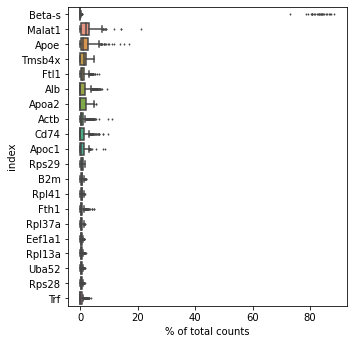

In [13]:
sc.pl.highest_expr_genes(adata, n_top=20, )


In [14]:
# check we don't have any weird cell types
adata.obs["scpred_CellType"].value_counts()


hepatocyte                     296
kupffer                        265
NK                             197
hepatic_sinusoid               107
b_cell                          97
myeloid_leukocyte               74
plasmacytoid_dendritic_cell     17
hepatic_stellate                 7
Name: scpred_CellType, dtype: int64

In [15]:
# write out data for BP and cibersort
dense_matrix = adata.X.todense()

sc_profile_file = os.path.join(aug_data_path, f"{res_name}_sig.pkl")
sc_profile_path = Path(sc_profile_file)

dense_df = pd.DataFrame(dense_matrix, columns = adata.var['gene_ids'])
dense_df.insert(loc=0, column='scpred_CellType', value=adata.obs["scpred_CellType"].to_list())


pickle.dump( dense_df, open( sc_profile_path, "wb" ) )


In [16]:
dense_matrix.shape

(1060, 13924)

# Plot Data

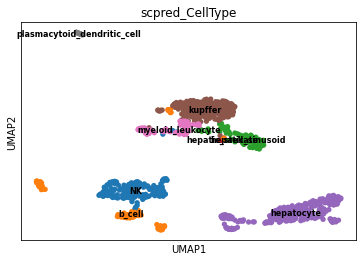

In [17]:
# valculate neighborhood graph
sc.pp.neighbors(adata)

# make umap
sc.tl.umap(adata)

# plot some markers of the RAW data
sc.pl.umap(adata, legend_loc='on data', color='scpred_CellType', legend_fontsize=8)


# Make Pseudobulks

### First do some QC stats

In [18]:
adata.obs["sample_id"].value_counts()


18-F-51    698
30-M-5     362
Name: sample_id, dtype: int64

In [19]:
adata.obs

,age,cell,cell_ontology_class,cell_ontology_id,free_annotation,method,mouse.id,n_genes,sex,subtissue,...,names_merged,keep,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,CellType,scpred_CellType,sample_id,stim
index,,,,,,,,,,,,,,,,,,,,,
AAACCTGAGATGTCGG-1-9-0-0,18m,MACA_18m_F_LIVER_HEPATOCYTES_51_AAACCTGAGATGTCGG,hepatocyte,NA,nan,droplet,18-F-51,1116,female,Hepatocytes,...,hepatocyte,yes,1115,2800.0,0.0,0.0,hepatocyte,hepatocyte,18-F-51,STIM
AAAGCAATCGGAAATA-1-9-0-0,18m,MACA_18m_F_LIVER_HEPATOCYTES_51_AAAGCAATCGGAAATA,hepatocyte,NA,"Hepatocyte (Pericentral, Midlobular, Periportal)",droplet,18-F-51,1976,female,Hepatocytes,...,hepatocyte,yes,1976,5403.0,0.0,0.0,hepatocyte,hepatocyte,18-F-51,STIM
AAAGTAGAGGCCCTTG-1-9-0-0,18m,MACA_18m_F_LIVER_HEPATOCYTES_51_AAAGTAGAGGCCCTTG,hepatocyte,NA,"Hepatocyte (Pericentral, Midlobular, Periportal)",droplet,18-F-51,1897,female,Hepatocytes,...,hepatocyte,yes,1897,4893.0,0.0,0.0,hepatocyte,hepatocyte,18-F-51,STIM
AACCGCGAGAAACCGC-1-9-0-0,18m,MACA_18m_F_LIVER_HEPATOCYTES_51_AACCGCGAGAAACCGC,hepatocyte,NA,"Hepatocyte (Pericentral, Midlobular, Periportal)",droplet,18-F-51,1501,female,Hepatocytes,...,hepatocyte,yes,1500,3691.0,0.0,0.0,hepatocyte,hepatocyte,18-F-51,STIM
AACTCCCAGTTGTCGT-1-9-0-0,18m,MACA_18m_F_LIVER_HEPATOCYTES_51_AACTCCCAGTTGTCGT,hepatocyte,NA,"Hepatocyte (Pericentral, Midlobular, Periportal)",droplet,18-F-51,1710,female,Hepatocytes,...,hepatocyte,yes,1709,4257.0,0.0,0.0,hepatocyte,hepatocyte,18-F-51,STIM
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTGAACGTCTGATACG-1-28-1-0,30m,10X_P2_11_TTGAACGTCTGATACG,NK cell,NA,NK/T,droplet,30-M-5,2273,male,LIVER_NPC,...,NK,yes,2271,8050.0,0.0,0.0,NK,NK,30-M-5,CTRL
TTGACTTCATCACGAT-1-28-1-0,30m,10X_P2_11_TTGACTTCATCACGAT,B cell,NA,nan,droplet,30-M-5,271,male,LIVER_NPC,...,b_cell,yes,271,4889.0,0.0,0.0,b_cell,b_cell,30-M-5,CTRL
TTGCGTCAGCAGATCG-1-28-1-0,30m,10X_P2_11_TTGCGTCAGCAGATCG,B cell,NA,B cell,droplet,30-M-5,530,male,LIVER_NPC,...,b_cell,yes,530,8514.0,0.0,0.0,b_cell,b_cell,30-M-5,CTRL


In [20]:
adata.obs["scpred_CellType"].unique()

['hepatocyte', 'hepatic_sinusoid', 'kupffer', 'hepatic_stellate', 'NK', 'plasmacytoid_dendritic_cell', 'b_cell', 'myeloid_leukocyte']
Categories (8, object): ['NK', 'b_cell', 'hepatic_sinusoid', 'hepatic_stellate', 'hepatocyte', 'kupffer', 'myeloid_leukocyte', 'plasmacytoid_dendritic_cell']

### now split test and train cells

In [21]:
# generate cell-type specific split
adata.obs["isTraining"] = "Train"


stim_idx = np.where(adata.obs.stim == "STIM")[0]
adata.obs["isTraining"][stim_idx] = "Test"


<ipython-input-21-6097bf4a867b>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs["isTraining"][stim_idx] = "Test"


In [22]:
pd.set_option('display.max_rows', 160)

tab = adata.obs.groupby(['stim', 'isTraining']).size()

tab.unstack()

isTraining,Test,Train
stim,,
CTRL,0,362
STIM,698,0


In [23]:
tab = adata.obs.groupby(['isTraining', 'sample_id']).size()

tab.unstack()

sample_id,18-F-51,30-M-5
isTraining,,
Test,698,0
Train,0,362


In [24]:
tab = adata.obs.groupby(['stim', 'sample_id']).size()

tab.unstack()

sample_id,18-F-51,30-M-5
stim,,
CTRL,0,362
STIM,698,0


## Make pseudobulks

In [63]:
from importlib import reload  # Python 3.4+
reload(sc_preprocess)


<module 'preprocessing.sc_preprocess' from '/beevol/home/davidson/checkouts/buddi/buddi/sc_preprocessing/2_make_pseudobulks/../../preprocessing/sc_preprocess.py'>

In [64]:
# write out the gene ids
gene_pass = adata.var['gene_ids']
gene_out_file = os.path.join(aug_data_path, f"{res_name}_genes.pkl")
gene_out_path = Path(gene_out_file)
pickle.dump( gene_pass, open( gene_out_path, "wb" ) )

# metadata
sample_order = ['18-F-51', '30-M-5']
stim_order = ['STIM', 'CTRL']
train_order = ['Train', 'Test']

# now generate all the proportions
total_meta_df = pd.DataFrame(columns = ["sample_id", "stim", "isTraining"])

# no cell noise 
len_vector = adata.obs["scpred_CellType"].unique().shape[0]
cell_noise = [np.random.lognormal(0, 0, adata.var['gene_ids'].shape[0]) for i in range(len_vector)]

# cell type order
cell_order = adata.obs.scpred_CellType.unique()

# simulate different number of cells
num_cells = 5000
idx = 0
for curr_samp in sample_order:
  for curr_stim in stim_order:
      for curr_train in train_order:

        print(f"running {curr_samp} {curr_stim} {curr_train}")


        # make the pseudobulks
        subset_idx = np.logical_and(adata.obs.sample_id == curr_samp, adata.obs.stim == curr_stim)
        subset_idx = np.where(np.logical_and(subset_idx, adata.obs.isTraining == curr_train))[0]
        if len(subset_idx) == 0:
            continue
        
        temp_adata = adata[subset_idx]

        print("make_prop_and_sum")
        prop_df, pseudobulks_df, test_prop_df, test_pseudobulks_df = sc_preprocess.make_prop_and_sum(temp_adata, 
                                                                                num_samples=1000, 
                                                                                num_cells=num_cells,
                                                                                use_true_prop=False,
                                                                                cell_noise=cell_noise,
                                                                                useSampleNoise=False)
        # number of random pseudobulks
        num_rand_pseudo = pseudobulks_df.shape[0] 

        # get the single cell type proportions
        print("get_single_celltype_prop_matrix")
        ct_prop_df = sc_preprocess.get_single_celltype_prop_matrix(num_samp=100,
                                                                    cell_order=cell_order)

        # now get the cell-type specific pseudobulks
        print("use_prop_make_sum")
        prop_df_sc, pseudobulks_df_sc, _ = sc_preprocess.use_prop_make_sum(temp_adata,  
                                                                            num_cells=num_cells, 
                                                                            props_vec=ct_prop_df, 
                                                                            cell_noise=cell_noise,
                                                                            sample_noise=None,
                                                                            useSampleNoise=False)
        # number of random pseudobulks
        num_ct_pseudo = pseudobulks_df_sc.shape[0] 


        # put them together
        print("concat")        
        prop_df = pd.concat([prop_df,prop_df_sc])
        pseudobulks_df = pd.concat([pseudobulks_df, pseudobulks_df_sc])

        # make the metadata
        num_samps = pseudobulks_df.shape[0] 
        samp_type = ["bulk"]*num_samps
        cell_prop_type = ["random"]*num_rand_pseudo+["cell_type_specific"]*num_ct_pseudo 
        samp_type = ["sc_ref"]*(num_rand_pseudo+num_ct_pseudo)
        
        metadata_df = pd.DataFrame(data = {"sample_id":[curr_samp]*num_samps, 
                                          "stim":[curr_stim]*num_samps,
                                          "isTraining":[curr_train]*num_samps,
                                          "cell_prop_type":cell_prop_type,
                                          "samp_type":samp_type,})

        # make the proportions instead of cell counts
        prop_df = prop_df.div(prop_df.sum(axis=1), axis=0)
        pseudobulk_file = os.path.join(aug_data_path, f"{res_name}_{curr_samp}_{curr_stim}_{curr_train}_pseudo_splits.pkl")
        prop_file = os.path.join(aug_data_path, f"{res_name}_{curr_samp}_{curr_stim}_{curr_train}_prop_splits.pkl")
        meta_file = os.path.join(aug_data_path, f"{res_name}_{curr_samp}_{curr_stim}_{curr_train}_meta_splits.pkl")

        print("write")        
        pseudobulk_path = Path(pseudobulk_file)
        prop_path = Path(prop_file)
        meta_path = Path(meta_file)
        #pickle.dump( prop_df, open( prop_path, "wb" ) )
        #pickle.dump( pseudobulks_df, open( pseudobulk_path, "wb" ) )
        pickle.dump( metadata_df, open( meta_path, "wb" ) )





running 18-F-51 STIM Train
running 18-F-51 STIM Test
make_prop_and_sum
0
100
200
300
400
500
600
700
800
900
1000
get_single_celltype_prop_matrix
use_prop_make_sum
0
100
200
300
400
500
600
700
concat
write
running 18-F-51 CTRL Train
running 18-F-51 CTRL Test
running 30-M-5 STIM Train
running 30-M-5 STIM Test
running 30-M-5 CTRL Train
make_prop_and_sum
0
100
200
300
400
500
600
700
800
900
1000
get_single_celltype_prop_matrix
use_prop_make_sum
0
100
200
300
400
500
600
700
concat
write
running 30-M-5 CTRL Test
